In [2]:
from transformers import pipeline
from PIL import Image
import requests
import torch

In [3]:
pipe = pipeline(
    "image-text-to-text",
    model="gbalachandhiran/medgemma-Histopathology-lung-colon",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

adapter_config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda


## We will sample about 500 images from the dataset for benchmarking

In [4]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gbalachandhiran
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:02<00:00, 941MB/s]


In [5]:


import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define the base directory
base_dir = "/content/lung-and-colon-cancer-histopathological-images"

# Define the subdirectories and their labels
categories = {
    "lung_colon_image_set/colon_image_sets/colon_aca": "Colon Adenocarcinoma",
    "lung_colon_image_set/colon_image_sets/colon_n": "Colon Normal",
    "lung_colon_image_set/lung_image_sets/lung_aca": "Lung Adenocarcinoma",
    "lung_colon_image_set/lung_image_sets/lung_n": "Lung Normal",
    "lung_colon_image_set/lung_image_sets/lung_scc": "Lung Squamous Cell Carcinoma",
}


## LEt us send the imaes for prediction we then store the prediction for later purpose

In [7]:

import pandas as pd
import random

# Define the number of images to sample per category
num_samples_per_category = 100

# List to store the sampled image paths and their true labels
sampled_images = []

# Iterate through each category and sample images
for subdir, label in categories.items():
    full_subdir_path = os.path.join(base_dir, subdir)
    image_files = [os.path.join(full_subdir_path, f) for f in os.listdir(full_subdir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sampled_images.extend([(img_path, label) for img_path in random.sample(image_files, min(num_samples_per_category, len(image_files)))])

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Image", "True Label", "Prediction"])



In [8]:
TISSUE_CLASSES = [
    "A: colon_aca",
    "B: colon_n",
    "C: lung_aca",
    "D: lung_n",
    "E: lung_scc"
]

options = "\n".join(TISSUE_CLASSES)
PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"

In [9]:
# Process images in batches of 2 and make predictions
batch_size = 2
for i in tqdm(range(0, len(sampled_images), batch_size), desc="Processing Images"):
    batch = sampled_images[i:i + batch_size]
    batch_data = []
    for image_path, true_label in batch:
        try:
            image = Image.open(image_path)
            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": "You are an expert radiologist."}]
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": PROMPT},
                        {"type": "image", "image": image},
                    ]
                }
            ]
            output = pipe(text=messages, max_new_tokens=50)
            prediction = output[0]["generated_text"][-1]["content"]
            batch_data.append({"Image": image_path, "True Label": true_label, "Prediction": prediction})
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            batch_data.append({"Image": image_path, "True Label": true_label, "Prediction": f"Error: {e}"})

    # Append the batch results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(batch_data)], ignore_index=True)

    # Print the DataFrame every 50 iterations
    if (i // batch_size + 1) % 50 == 0:
        print(f"DataFrame after processing {i + batch_size} images:")
        display(results_df.tail())

Processing Images:   0%|          | 0/250 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
You seem to be using the pipelines sequen

DataFrame after processing 100 images:


,Image,True Label,Prediction
95,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca
96,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca
97,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca
98,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca
99,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 200 images:


,Image,True Label,Prediction
195,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,A: colon_aca
196,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,A: colon_aca
197,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,A: colon_aca
198,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,A: colon_aca
199,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,A: colon_aca


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 300 images:


,Image,True Label,Prediction
295,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,C: lung_aca
296,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,C: lung_aca
297,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,C: lung_aca
298,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,C: lung_aca
299,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,C: lung_aca


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 400 images:


,Image,True Label,Prediction
395,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,C: lung_aca
396,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,D: lung_n
397,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,C: lung_aca
398,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,D: lung_n
399,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,D: lung_n


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 500 images:


,Image,True Label,Prediction
495,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca
496,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca
497,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca
498,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,E: lung_scc
499,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca


In [23]:
print(results_df.head(15))

                                                Image            True Label  \
0   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
1   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
2   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
3   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
4   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
5   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
6   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
7   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
8   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
9   /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
10  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
11  /content/lung-and-colon-cancer-histopathologic..

In [10]:
results_df['True Label'].value_counts()

,count
True Label,
Colon Adenocarcinoma,100
Colon Normal,100
Lung Adenocarcinoma,100
Lung Normal,100
Lung Squamous Cell Carcinoma,100


In [11]:


label_mapping = {
    "Colon Adenocarcinoma": "A: colon_aca",
    "Colon Normal": "B: colon_n",
    "Lung Adenocarcinoma": "C: lung_aca",
    "Lung Normal": "D: lung_n",
    "Lung Squamous Cell Carcinoma": "E: lung_scc"
}
results_df['Mapped True Label'] = results_df['True Label'].map(label_mapping)

In [12]:
results_df

,Image,True Label,Prediction,Mapped True Label
0,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca,A: colon_aca
1,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca,A: colon_aca
2,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca,A: colon_aca
3,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca,A: colon_aca
4,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,A: colon_aca,A: colon_aca
...,...,...,...,...
495,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca,E: lung_scc
496,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca,E: lung_scc
497,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,C: lung_aca,E: lung_scc
498,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,E: lung_scc,E: lung_scc


In [13]:
results_df.to_csv('results_df.csv', index=False)

## We will now create classification report as heatmap

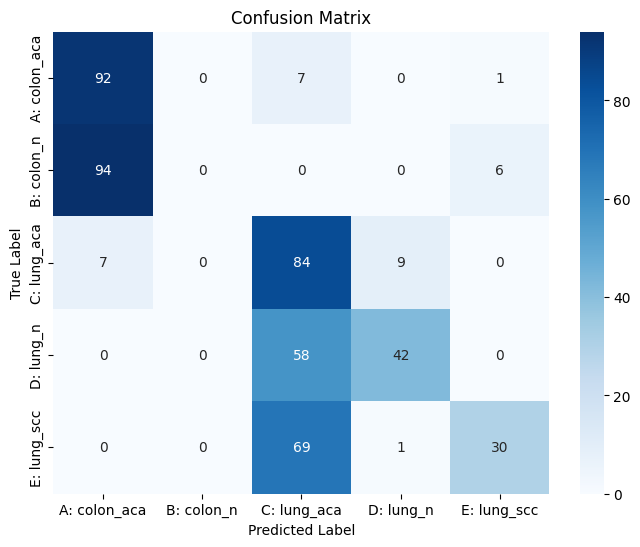

In [14]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = results_df['Prediction']
y_true = results_df['Mapped True Label']

# Remove rows with errors in predictions
valid_indices = ~y_pred.str.contains("Error:")
y_pred_cleaned = y_pred[valid_indices]
y_true_cleaned = y_true[valid_indices]

# Get unique labels from both true and predicted labels
unique_labels = sorted(list(set(y_true_cleaned).union(set(y_pred_cleaned))))

# Calculate the confusion matrix
cm = confusion_matrix(y_true_cleaned, y_pred_cleaned, labels=unique_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




In [15]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true_cleaned, y_pred_cleaned, labels=unique_labels, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

A: colon_aca       0.48      0.92      0.63       100
  B: colon_n       0.00      0.00      0.00       100
 C: lung_aca       0.39      0.84      0.53       100
   D: lung_n       0.81      0.42      0.55       100
 E: lung_scc       0.81      0.30      0.44       100

    accuracy                           0.50       500
   macro avg       0.50      0.50      0.43       500
weighted avg       0.50      0.50      0.43       500



## We will not do Medgemma original version

In [16]:
from transformers import pipeline
from PIL import Image
import requests
import torch

pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [17]:
# prompt: Sample about 500 images from
# /content/lung-and-colon-cancer-histopathological-images
# equally from all the folder inthe above path. We will createa a data frame
# Image ,true Label:Folder name, Prediction model Prediction.
# Let us first sample them and we will send them as batch of 2 for prediction  using the following pipeline
# image_url = "/content/Nomral.jpeg"
# # Use Image.open() directly with the local file path
# image = Image.open(image_url)
# TISSUE_CLASSES = [
#     "A: colon_aca",
#     "B: colon_n",
#     "C: lung_aca",
#     "D: lung_n",
#     "E: lung_scc"
# ]
# options = "\n".join(TISSUE_CLASSES)
# PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"
# messages = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are an expert radiologist."}]
#     },
#     {
#         "role": "user",
#         "content": [
#             {"type": "text", "text": PROMPT},
#             {"type": "image", "image": image},
#         ]
#     }
# ]
# output = pipe(text=messages, max_new_tokens=50)
# print(output[0]["generated_text"][-1]["content"])
# here output= prediction

import pandas as pd
import random

# Define the number of images to sample per category
num_samples_per_category = 100

# List to store the sampled image paths and their true labels
sampled_images = []

# Iterate through each category and sample images
for subdir, label in categories.items():
    full_subdir_path = os.path.join(base_dir, subdir)
    image_files = [os.path.join(full_subdir_path, f) for f in os.listdir(full_subdir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sampled_images.extend([(img_path, label) for img_path in random.sample(image_files, min(num_samples_per_category, len(image_files)))])

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Image", "True Label", "Prediction"])



In [18]:
TISSUE_CLASSES = [
    "A: colon_aca",
    "B: colon_n",
    "C: lung_aca",
    "D: lung_n",
    "E: lung_scc"
]

options = "\n".join(TISSUE_CLASSES)
PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"

In [19]:
# Process images in batches of 2 and make predictions
batch_size = 2
for i in tqdm(range(0, len(sampled_images), batch_size), desc="Processing Images"):
    batch = sampled_images[i:i + batch_size]
    batch_data = []
    for image_path, true_label in batch:
        try:
            image = Image.open(image_path)
            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": "You are an expert radiologist."}]
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": PROMPT},
                        {"type": "image", "image": image},
                    ]
                }
            ]
            output = pipe(text=messages, max_new_tokens=50)
            prediction = output[0]["generated_text"][-1]["content"]
            batch_data.append({"Image": image_path, "True Label": true_label, "Prediction": prediction})
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            batch_data.append({"Image": image_path, "True Label": true_label, "Prediction": f"Error: {e}"})

    # Append the batch results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(batch_data)], ignore_index=True)

    # Print the DataFrame every 50 iterations
    if (i // batch_size + 1) % 50 == 0:
        print(f"DataFrame after processing {i + batch_size} images:")
        display(results_df.tail())

Processing Images:   0%|          | 0/250 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 100 images:


,Image,True Label,Prediction
95,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li..."
96,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li..."
97,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the provided histopathology image, th..."
98,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histological image provided, the ..."
99,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li..."


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 200 images:


,Image,True Label,Prediction
195,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,"Based on the histological image, the most like..."
196,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,"Based on the histopathology image, the most li..."
197,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,"Based on the histopathology image, the most li..."
198,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,The most likely tissue type shown in the histo...
199,/content/lung-and-colon-cancer-histopathologic...,Colon Normal,"Based on the microscopic appearance, the most ..."


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 300 images:


,Image,True Label,Prediction
295,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,"Based on the histopathology image, the most li..."
296,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,"Based on the histopathology image, the most li..."
297,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,"Based on the histopathology image, the most li..."
298,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,"Based on the provided histopathology image, th..."
299,/content/lung-and-colon-cancer-histopathologic...,Lung Adenocarcinoma,"Based on the histological image, the most like..."


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 400 images:


,Image,True Label,Prediction
395,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,"Based on the histopathology image provided, th..."
396,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,"Based on the provided histopathology image, th..."
397,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,"Based on the microscopic image, the most likel..."
398,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,"Based on the provided histopathology image, th..."
399,/content/lung-and-colon-cancer-histopathologic...,Lung Normal,"Based on the histopathology image, the most li..."


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for o

DataFrame after processing 500 images:


,Image,True Label,Prediction
495,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,"Based on the histopathology image, the most li..."
496,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,"Based on the histopathology image, the most li..."
497,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,"Based on the histopathology image, the most li..."
498,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,"Based on the histopathology image, the most li..."
499,/content/lung-and-colon-cancer-histopathologic...,Lung Squamous Cell Carcinoma,"Based on the histopathology image, the most li..."


In [26]:

label_mapping = {
    "Colon Adenocarcinoma": "A: colon_aca",
    "Colon Normal": "B: colon_n",
    "Lung Adenocarcinoma": "C: lung_aca",
    "Lung Normal": "D: lung_n",
    "Lung Squamous Cell Carcinoma": "E: lung_scc"
}
results_df['Mapped True Label'] = results_df['True Label'].map(label_mapping)

In [36]:
# prompt: Create a new column called True prediction from Mapped True Label column extracting only the keywords present in  if one of these  below match what you see in Mapped True Label then True prediction should that word match from the list below
#  "A: colon_aca",
#     "B: colon_n",
#     "C: lung_aca",
#     "D: lung_n",
#     "E: lung_scc"

def extract_true_prediction(prediction_text):
    """Extracts the keyword from the Prediction text if it matches a predefined list,
    returning "Model not sure" if more than one keyword is found."""
    tissue_keywords = ["A: colon_aca", "B: colon_n", "C: lung_aca", "D: lung_n", "E: lung_scc"]
    if pd.isna(prediction_text):
        return None

    found_keywords = [keyword for keyword in tissue_keywords if keyword in prediction_text]

    if len(found_keywords) == 1:
        return found_keywords[0]
    else:
        return "Model not sure"


results_df['True prediction'] = results_df['Prediction'].apply(extract_true_prediction)
print(results_df.head())

                                               Image            True Label  \
0  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
1  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
2  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
3  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   
4  /content/lung-and-colon-cancer-histopathologic...  Colon Adenocarcinoma   

                                          Prediction Mapped True Label  \
0  Based on the histopathology image, the most li...      A: colon_aca   
1  Based on the histopathology image, the most li...      A: colon_aca   
2  Based on the histopathology image, the most li...      A: colon_aca   
3  Based on the histopathology image, the most li...      A: colon_aca   
4  Based on the histopathology image, the most li...      A: colon_aca   

  True prediction  
0    A: colon_aca  
1    A: colon_aca  
2  Model not sure  
3    A

In [37]:
results_df.head()

,Image,True Label,Prediction,Mapped True Label,True prediction
0,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li...",A: colon_aca,A: colon_aca
1,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li...",A: colon_aca,A: colon_aca
2,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li...",A: colon_aca,Model not sure
3,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li...",A: colon_aca,A: colon_aca
4,/content/lung-and-colon-cancer-histopathologic...,Colon Adenocarcinoma,"Based on the histopathology image, the most li...",A: colon_aca,E: lung_scc


In [38]:
results_df.to_csv('results_df_medgemma_original.csv', index=False)

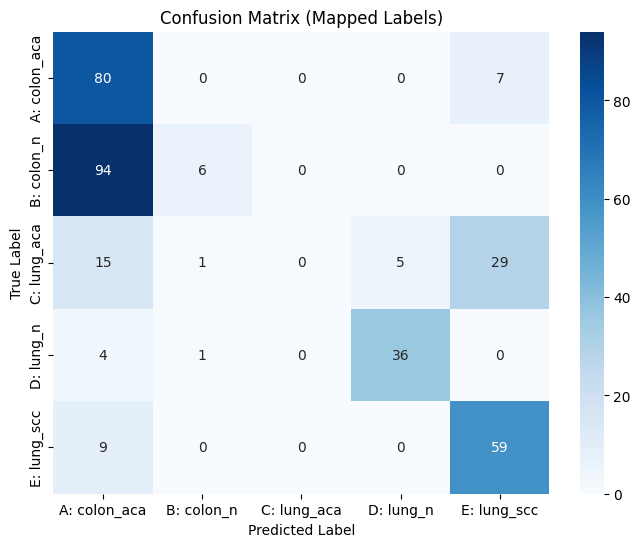


Classification Report (Mapped Labels):
              precision    recall  f1-score   support

A: colon_aca       0.40      0.92      0.55        87
  B: colon_n       0.75      0.06      0.11       100
 C: lung_aca       0.00      0.00      0.00        50
   D: lung_n       0.88      0.88      0.88        41
 E: lung_scc       0.62      0.87      0.72        68

    accuracy                           0.52       346
   macro avg       0.53      0.55      0.45       346
weighted avg       0.54      0.52      0.42       346



In [41]:
# prompt: Generate a confusion matrix between Mapped True Label and True prediction with heatmap later lets print classification report

y_true_mapped = results_df['Mapped True Label']
y_pred_mapped = results_df['True prediction']

# Handle potential 'Model not sure' predictions by removing them for the confusion matrix and classification report
valid_indices = y_pred_mapped != 'Model not sure'
y_true_cleaned_mapped = y_true_mapped[valid_indices]
y_pred_cleaned_mapped = y_pred_mapped[valid_indices]

# Get unique labels from both true and predicted labels for the cleaned data
unique_labels_mapped = sorted(list(set(y_true_cleaned_mapped).union(set(y_pred_cleaned_mapped))))

# Calculate the confusion matrix for mapped labels
cm_mapped = confusion_matrix(y_true_cleaned_mapped, y_pred_cleaned_mapped, labels=unique_labels_mapped)

# Create a heatmap for the confusion matrix with mapped labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_mapped, yticklabels=unique_labels_mapped)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Mapped Labels)')
plt.show()

# Print the classification report for mapped labels
print("\nClassification Report (Mapped Labels):")
print(classification_report(y_true_cleaned_mapped, y_pred_cleaned_mapped, labels=unique_labels_mapped, zero_division=0))